In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import pickle

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

#Paths 
CHALLENGE_PATH = "C:/Chazal/ChallengeIFPEN2018/"
DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Data/"
TOOLS_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Tools/"

#Some constants
DEFAULT_SIZE = [175,152,152]
NB_INPUT_IMG = 400

#Home made tools for persistence features
os.chdir("C:/Seafile/Ma bibliothèque/Chazal2/MyPython36") 
from DTM import *
#from persistent_surface import *
from PdiagFeatures import *

#Classes provided with the data 
os.chdir(TOOLS_PATH)
from Image3D import Image3D
from ImageIO import ImageIO

In [90]:
from __future__ import print_function, division

import keras
from keras.layers import Convolution1D, Dense, Input, MaxPooling1D, Flatten, Dropout, Activation
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.optimizers import RMSprop


In [3]:
#sklearn stuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

In [10]:
def load_outputs(output_path=CHALLENGE_PATH):
    csv_path = os.path.join(output_path,"challenge_fichier_de_sortie_dentrainement_prediction_de_la_saturation_dhuile_residuelle.csv")
    return pd.read_csv(csv_path,sep=';')

DEFAULT_SIZE = [175,152,152]

def load_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_img3D = []
    for nb in range(400):
        file_name = data_path + "input_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_img3D.append(img)
    return list_img3D

def load_output_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_out_img3D = []
    for nb in range(400):
        file_name = data_path + "output_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_out_img3D.append(img)
    return list_out_img3D

In [11]:
outputs = load_outputs()

## 1. Load features data

### 1.1 Non persistent features

In [5]:
Feat_vol_voids = pickle.load(open(CHALLENGE_PATH + "Feat_vol_voids.dat", "rb"), encoding="latin1")
kNN=1
Feat_volDTM_voids = pickle.load(open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids.dat", "rb"), encoding="latin1")
Feat_area_bd = pickle.load(open(CHALLENGE_PATH + "Feat_area_bd.dat", "rb"), encoding="latin1")
Feat_vol_slices = pickle.load(open(CHALLENGE_PATH + "Voids_slices.dat", "rb"), encoding="latin1")
Feat_length_slices = pickle.load(open(CHALLENGE_PATH + "Length_slices.dat","rb"),encoding="latin1")
Feat_loc_max = pickle.load(open(CHALLENGE_PATH + "Feat_Locmax.dat", "rb"),encoding="latin1")
Feat_density_hist = pickle.load(open(CHALLENGE_PATH + "SetDensity2_hist.dat", "rb"),encoding="latin1")
#Not saved but easy and fast to compute (from cells above):
# Feat_mat

### 1.2 Persistence images (from scaled diagrams)

In [6]:
file_names = ["Feat_DTM1_scaled_","Feat_SetIntensity2_scaled_","Feat_hX_scaled_","Feat_hY_scaled_","Feat_hZ_scaled_",\
             "Feat_locmax_dist_scaled_"]

#pers_test = ["pers0_test.dat","pers1_test.dat","pers2_test.dat"]
pers_train = ["pers0.dat","pers1.dat","pers2.dat"]

pers = pers_train

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_scaled_"]
Feat_names_pers = ["pers0","pers1","pers2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(pers)):
        vn = Feat_names[idx] + Feat_names_pers[jdx]
        fn = file_names[idx] + pers[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 

### 1.3 Min-max birth-death

In [7]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_"]

bd_test = ["bd0_test.dat","bd1_test.dat","bd2_test.dat"]
bd_train = ["bd0.dat","bd1.dat","bd2.dat"]

#if TrainTest == "Train":
bd = bd_train
#else:
#    bd = bd_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_bd = ["bd0","bd1","bd2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_bd[jdx]
        fn = file_names[idx] + bd[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_bd = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_bd.append(v[vn[0]])

Feat_bd = np.concatenate(list_Feat_bd,axis=1)
#print(np.shape(Feat_bd))

### 1.4 Entropy curves

In [8]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_"]

ent_test = ["ent0_test.dat","ent1_test.dat","ent2_test.dat"]
ent_train = ["ent0.dat","ent1.dat","ent2.dat"]

#if TrainTest == "Train":
ent = ent_train
#else:
#    ent = ent_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_ent = ["ent0","ent1","ent2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + ent[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_ent = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_ent.append(v[vn[0]])
Feat_ent = np.concatenate(list_Feat_ent,axis=1)

In [12]:
encoder = LabelEncoder()
material_cat = outputs["material"]
Feat_mat = encoder.fit_transform(material_cat)
Feat_mat = np.reshape(Feat_mat,(400,1))

### 1.5 Concatenate features

In [183]:
Feat_vol_voids = np.reshape(Feat_vol_voids,(NB_INPUT_IMG,1))
Feat_volDTM_voids = np.reshape(Feat_volDTM_voids,(NB_INPUT_IMG,1))

#Feat_mat: encode material. WARNING! This is not a real feature, it needs to be predicted first.  


#Feat_bd has been defined while laoding all the min_max birth_death above. 
#Feat_ent has been defined while loading all the entropy features above

#Subselect some of the Entropy curves: 
nb_x_steps = 20
Feat_ent_DTM1 = Feat_ent[:,0:3*nb_x_steps]
Feat_ent_Intensity2 = Feat_ent[:,3*nb_x_steps:6*nb_x_steps]
Feat_ent_hX = Feat_ent[:,6*nb_x_steps:9*nb_x_steps]
Feat_ent_hY = Feat_ent[:,9*nb_x_steps:12*nb_x_steps]
Feat_ent_hZ = Feat_ent[:,12*nb_x_steps:15*nb_x_steps]
Feat_ent_locmax_dist = Feat_ent[:,15*nb_x_steps:18*nb_x_steps]

Feat_density = Feat_density_hist
Feat_slices = np.concatenate([Feat_vol_slices,Feat_length_slices],axis=1)
Feat_Voids = np.concatenate([Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd],axis=1)
#Feat_DTM30_pers = np.concatenate([Feat_DTM30_pers0,Feat_DTM30_pers1,Feat_DTM30_pers2],axis=1)
Feat_DTM1_pers = np.concatenate([Feat_DTM1_pers0,Feat_DTM1_pers1,Feat_DTM1_pers2],axis=1)
#Feat_locmax_pers = np.concatenate([Feat_locmax_pers0,Feat_locmax_pers1,Feat_locmax_pers2],axis=1)
#Feat_locmax_dist_pers = np.concatenate([Feat_locmax_dist_pers0,Feat_locmax_dist_pers1,Feat_locmax_dist_pers2],axis=1)
Feat_SetIntensity2_pers = np.concatenate([Feat_SetIntensity2_pers0,Feat_SetIntensity2_pers1,Feat_SetIntensity2_pers2],axis=1)
Feat_hX_pers =np.concatenate([Feat_hX_pers0,Feat_hX_pers1,Feat_hX_pers2],axis=1)
Feat_hY_pers =np.concatenate([Feat_hY_pers0,Feat_hY_pers1,Feat_hY_pers2],axis=1)
Feat_hZ_pers =np.concatenate([Feat_hZ_pers0,Feat_hZ_pers1,Feat_hZ_pers2],axis=1)

In [184]:
nb_x_steps = 20

TS_input = Feat_ent[:,0:6*nb_x_steps] #DTM1 and intensity
TS_input = np.reshape(TS_input,(np.shape(TS_input)[0],nb_x_steps,-1))

print(np.shape(TS_input))

Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density, Feat_bd],axis=1)
print(np.shape(Feat))

(400, 20, 6)
(400, 127)


In [185]:
TS_train, TS_test, Feat_train, Feat_test, y_train, y_test = train_test_split(TS_input, Feat, outputs["sor"], test_size = 0.2)

### Simple 1D CNN taking only entropy curves

In [197]:
nb_filter = 32
kernel_length = 3
window_size = np.shape(TS_input)[1]
nb_input_series = np.shape(TS_input)[2]
nb_outputs = 1

model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(activation='relu', input_shape=(window_size, nb_input_series),\
                      filters=nb_filter, kernel_size=kernel_length),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(activation='relu',filters=nb_filter, kernel_size=kernel_length),
        MaxPooling1D(),
        Flatten(),
        #keras.layers.BatchNormalization(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [198]:
model.fit(TS_train, y_train, nb_epoch=2000, batch_size=320, validation_data=(TS_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 320 samples, validate on 80 samples
Epoch 1/2000
320/320 [==============================] - 3s 9ms/step - loss: 0.2573 - mean_absolute_error: 0.4498 - val_loss: 0.6109 - val_mean_absolute_error: 0.7423
Epoch 2/2000
320/320 [==============================] - 0s 44us/step - loss: 0.6454 - mean_absolute_error: 0.7690 - val_loss: 0.2004 - val_mean_absolute_error: 0.3844
Epoch 3/2000
320/320 [==============================] - 0s 38us/step - loss: 0.2162 - mean_absolute_error: 0.4121 - val_loss: 0.0947 - val_mean_absolute_error: 0.2513
Epoch 4/2000
320/320 [==============================] - 0s 47us/step - loss: 0.0847 - mean_absolute_error: 0.2336 - val_loss: 0.3348 - val_mean_absolute_error: 0.5289
Epoch 5/2000
320/320 [==============================] - 0s 63us/step - loss: 0.3100 - mean_absolute_error: 0.5061 - val_loss: 0.2882 - val_mean_absolute_error: 0.4881
Epoch 6/2000
320/320 [==============================] - 0s 88us/step - loss: 0.2657 - mean_absolute_error: 0.4642 - val_l

Epoch 50/2000
320/320 [==============================] - 0s 53us/step - loss: 0.0240 - mean_absolute_error: 0.1218 - val_loss: 0.0321 - val_mean_absolute_error: 0.1474
Epoch 51/2000
320/320 [==============================] - 0s 144us/step - loss: 0.0252 - mean_absolute_error: 0.1239 - val_loss: 0.0316 - val_mean_absolute_error: 0.1461
Epoch 52/2000
320/320 [==============================] - 0s 62us/step - loss: 0.0247 - mean_absolute_error: 0.1228 - val_loss: 0.0291 - val_mean_absolute_error: 0.1382
Epoch 53/2000
320/320 [==============================] - 0s 19us/step - loss: 0.0229 - mean_absolute_error: 0.1196 - val_loss: 0.0276 - val_mean_absolute_error: 0.1326
Epoch 54/2000
320/320 [==============================] - 0s 122us/step - loss: 0.0225 - mean_absolute_error: 0.1208 - val_loss: 0.0278 - val_mean_absolute_error: 0.1303
Epoch 55/2000
320/320 [==============================] - 0s 51us/step - loss: 0.0233 - mean_absolute_error: 0.1242 - val_loss: 0.0277 - val_mean_absolute_erro

Epoch 99/2000
320/320 [==============================] - 0s 52us/step - loss: 0.0143 - mean_absolute_error: 0.0958 - val_loss: 0.0231 - val_mean_absolute_error: 0.1193
Epoch 100/2000
320/320 [==============================] - 0s 106us/step - loss: 0.0141 - mean_absolute_error: 0.0955 - val_loss: 0.0230 - val_mean_absolute_error: 0.1192
Epoch 101/2000
320/320 [==============================] - 0s 47us/step - loss: 0.0140 - mean_absolute_error: 0.0950 - val_loss: 0.0230 - val_mean_absolute_error: 0.1194
Epoch 102/2000
320/320 [==============================] - 0s 118us/step - loss: 0.0139 - mean_absolute_error: 0.0945 - val_loss: 0.0230 - val_mean_absolute_error: 0.1193
Epoch 103/2000
320/320 [==============================] - 0s 54us/step - loss: 0.0138 - mean_absolute_error: 0.0940 - val_loss: 0.0228 - val_mean_absolute_error: 0.1190
Epoch 104/2000
320/320 [==============================] - 0s 62us/step - loss: 0.0137 - mean_absolute_error: 0.0937 - val_loss: 0.0227 - val_mean_absolute

Epoch 148/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0102 - mean_absolute_error: 0.0806 - val_loss: 0.0196 - val_mean_absolute_error: 0.1089
Epoch 149/2000
320/320 [==============================] - 0s 132us/step - loss: 0.0102 - mean_absolute_error: 0.0803 - val_loss: 0.0196 - val_mean_absolute_error: 0.1088
Epoch 150/2000
320/320 [==============================] - 0s 44us/step - loss: 0.0101 - mean_absolute_error: 0.0801 - val_loss: 0.0195 - val_mean_absolute_error: 0.1087
Epoch 151/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0100 - mean_absolute_error: 0.0798 - val_loss: 0.0195 - val_mean_absolute_error: 0.1085
Epoch 152/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0100 - mean_absolute_error: 0.0796 - val_loss: 0.0194 - val_mean_absolute_error: 0.1084
Epoch 153/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0099 - mean_absolute_error: 0.0793 - val_loss: 0.0194 - val_mean_absolute

Epoch 197/2000
320/320 [==============================] - 0s 44us/step - loss: 0.0077 - mean_absolute_error: 0.0697 - val_loss: 0.0175 - val_mean_absolute_error: 0.1026
Epoch 198/2000
320/320 [==============================] - 0s 29us/step - loss: 0.0077 - mean_absolute_error: 0.0695 - val_loss: 0.0175 - val_mean_absolute_error: 0.1025
Epoch 199/2000
320/320 [==============================] - 0s 69us/step - loss: 0.0076 - mean_absolute_error: 0.0693 - val_loss: 0.0175 - val_mean_absolute_error: 0.1024
Epoch 200/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0076 - mean_absolute_error: 0.0692 - val_loss: 0.0174 - val_mean_absolute_error: 0.1023
Epoch 201/2000
320/320 [==============================] - 0s 59us/step - loss: 0.0076 - mean_absolute_error: 0.0690 - val_loss: 0.0174 - val_mean_absolute_error: 0.1023
Epoch 202/2000
320/320 [==============================] - 0s 42us/step - loss: 0.0075 - mean_absolute_error: 0.0688 - val_loss: 0.0174 - val_mean_absolute_

Epoch 246/2000
320/320 [==============================] - 0s 100us/step - loss: 0.0060 - mean_absolute_error: 0.0618 - val_loss: 0.0160 - val_mean_absolute_error: 0.0990
Epoch 247/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0060 - mean_absolute_error: 0.0617 - val_loss: 0.0160 - val_mean_absolute_error: 0.0989
Epoch 248/2000
320/320 [==============================] - 0s 130us/step - loss: 0.0059 - mean_absolute_error: 0.0615 - val_loss: 0.0159 - val_mean_absolute_error: 0.0989
Epoch 249/2000
320/320 [==============================] - 0s 103us/step - loss: 0.0059 - mean_absolute_error: 0.0614 - val_loss: 0.0159 - val_mean_absolute_error: 0.0988
Epoch 250/2000
320/320 [==============================] - 0s 40us/step - loss: 0.0059 - mean_absolute_error: 0.0613 - val_loss: 0.0159 - val_mean_absolute_error: 0.0988
Epoch 251/2000
320/320 [==============================] - 0s 43us/step - loss: 0.0059 - mean_absolute_error: 0.0611 - val_loss: 0.0158 - val_mean_absolu

Epoch 295/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0049 - mean_absolute_error: 0.0554 - val_loss: 0.0152 - val_mean_absolute_error: 0.0961
Epoch 296/2000
320/320 [==============================] - 0s 97us/step - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0152 - val_mean_absolute_error: 0.0960
Epoch 297/2000
320/320 [==============================] - 0s 56us/step - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0152 - val_mean_absolute_error: 0.0960
Epoch 298/2000
320/320 [==============================] - 0s 21us/step - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0152 - val_mean_absolute_error: 0.0959
Epoch 299/2000
320/320 [==============================] - 0s 52us/step - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0152 - val_mean_absolute_error: 0.0958
Epoch 300/2000
320/320 [==============================] - 0s 96us/step - loss: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0151 - val_mean_absolute_

Epoch 344/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0041 - mean_absolute_error: 0.0506 - val_loss: 0.0146 - val_mean_absolute_error: 0.0933
Epoch 345/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0041 - mean_absolute_error: 0.0505 - val_loss: 0.0145 - val_mean_absolute_error: 0.0932
Epoch 346/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0041 - mean_absolute_error: 0.0504 - val_loss: 0.0145 - val_mean_absolute_error: 0.0932
Epoch 347/2000
320/320 [==============================] - 0s 112us/step - loss: 0.0040 - mean_absolute_error: 0.0503 - val_loss: 0.0145 - val_mean_absolute_error: 0.0932
Epoch 348/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0145 - val_mean_absolute_error: 0.0931
Epoch 349/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0145 - val_mean_absolute

Epoch 393/2000
320/320 [==============================] - 0s 81us/step - loss: 0.0035 - mean_absolute_error: 0.0468 - val_loss: 0.0139 - val_mean_absolute_error: 0.0904
Epoch 394/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0035 - mean_absolute_error: 0.0467 - val_loss: 0.0139 - val_mean_absolute_error: 0.0903
Epoch 395/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0035 - mean_absolute_error: 0.0466 - val_loss: 0.0139 - val_mean_absolute_error: 0.0902
Epoch 396/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0035 - mean_absolute_error: 0.0466 - val_loss: 0.0139 - val_mean_absolute_error: 0.0902
Epoch 397/2000
320/320 [==============================] - 0s 81us/step - loss: 0.0035 - mean_absolute_error: 0.0465 - val_loss: 0.0139 - val_mean_absolute_error: 0.0903
Epoch 398/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0035 - mean_absolute_error: 0.0465 - val_loss: 0.0139 - val_mean_absolute_

Epoch 442/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0031 - mean_absolute_error: 0.0436 - val_loss: 0.0133 - val_mean_absolute_error: 0.0883
Epoch 443/2000
320/320 [==============================] - 0s 47us/step - loss: 0.0031 - mean_absolute_error: 0.0435 - val_loss: 0.0133 - val_mean_absolute_error: 0.0882
Epoch 444/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0031 - mean_absolute_error: 0.0434 - val_loss: 0.0132 - val_mean_absolute_error: 0.0882
Epoch 445/2000
320/320 [==============================] - 0s 44us/step - loss: 0.0031 - mean_absolute_error: 0.0434 - val_loss: 0.0132 - val_mean_absolute_error: 0.0882
Epoch 446/2000
320/320 [==============================] - 0s 44us/step - loss: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0133 - val_mean_absolute_error: 0.0882
Epoch 447/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0132 - val_mean_absolute_

Epoch 491/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0028 - mean_absolute_error: 0.0413 - val_loss: 0.0130 - val_mean_absolute_error: 0.0875
Epoch 492/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0028 - mean_absolute_error: 0.0412 - val_loss: 0.0129 - val_mean_absolute_error: 0.0874
Epoch 493/2000
320/320 [==============================] - 0s 42us/step - loss: 0.0028 - mean_absolute_error: 0.0412 - val_loss: 0.0129 - val_mean_absolute_error: 0.0874
Epoch 494/2000
320/320 [==============================] - 0s 150us/step - loss: 0.0028 - mean_absolute_error: 0.0411 - val_loss: 0.0130 - val_mean_absolute_error: 0.0875
Epoch 495/2000
320/320 [==============================] - 0s 59us/step - loss: 0.0028 - mean_absolute_error: 0.0411 - val_loss: 0.0130 - val_mean_absolute_error: 0.0875
Epoch 496/2000
320/320 [==============================] - 0s 43us/step - loss: 0.0028 - mean_absolute_error: 0.0410 - val_loss: 0.0129 - val_mean_absolute

Epoch 540/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0026 - mean_absolute_error: 0.0393 - val_loss: 0.0127 - val_mean_absolute_error: 0.0871
Epoch 541/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0026 - mean_absolute_error: 0.0392 - val_loss: 0.0127 - val_mean_absolute_error: 0.0871
Epoch 542/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0026 - mean_absolute_error: 0.0392 - val_loss: 0.0127 - val_mean_absolute_error: 0.0870
Epoch 543/2000
320/320 [==============================] - 0s 62us/step - loss: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0127 - val_mean_absolute_error: 0.0869
Epoch 544/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0127 - val_mean_absolute_error: 0.0870
Epoch 545/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0127 - val_mean_absolute_

Epoch 589/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0024 - mean_absolute_error: 0.0373 - val_loss: 0.0124 - val_mean_absolute_error: 0.0864
Epoch 590/2000
320/320 [==============================] - 0s 95us/step - loss: 0.0024 - mean_absolute_error: 0.0373 - val_loss: 0.0124 - val_mean_absolute_error: 0.0864
Epoch 591/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0124 - val_mean_absolute_error: 0.0864
Epoch 592/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0023 - mean_absolute_error: 0.0372 - val_loss: 0.0124 - val_mean_absolute_error: 0.0863
Epoch 593/2000
320/320 [==============================] - 0s 52us/step - loss: 0.0023 - mean_absolute_error: 0.0372 - val_loss: 0.0124 - val_mean_absolute_error: 0.0862
Epoch 594/2000
320/320 [==============================] - 0s 42us/step - loss: 0.0023 - mean_absolute_error: 0.0371 - val_loss: 0.0124 - val_mean_absolute_

Epoch 638/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0121 - val_mean_absolute_error: 0.0854
Epoch 639/2000
320/320 [==============================] - 0s 103us/step - loss: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0121 - val_mean_absolute_error: 0.0853
Epoch 640/2000
320/320 [==============================] - 0s 84us/step - loss: 0.0022 - mean_absolute_error: 0.0356 - val_loss: 0.0121 - val_mean_absolute_error: 0.0854
Epoch 641/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0022 - mean_absolute_error: 0.0355 - val_loss: 0.0121 - val_mean_absolute_error: 0.0855
Epoch 642/2000
320/320 [==============================] - 0s 42us/step - loss: 0.0022 - mean_absolute_error: 0.0355 - val_loss: 0.0121 - val_mean_absolute_error: 0.0854
Epoch 643/2000
320/320 [==============================] - 0s 92us/step - loss: 0.0022 - mean_absolute_error: 0.0354 - val_loss: 0.0120 - val_mean_absolute

Epoch 687/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0020 - mean_absolute_error: 0.0339 - val_loss: 0.0118 - val_mean_absolute_error: 0.0845
Epoch 688/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0020 - mean_absolute_error: 0.0339 - val_loss: 0.0118 - val_mean_absolute_error: 0.0845
Epoch 689/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0020 - mean_absolute_error: 0.0338 - val_loss: 0.0118 - val_mean_absolute_error: 0.0844
Epoch 690/2000
320/320 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0338 - val_loss: 0.0118 - val_mean_absolute_error: 0.0843
Epoch 691/2000
320/320 [==============================] - 0s 51us/step - loss: 0.0020 - mean_absolute_error: 0.0337 - val_loss: 0.0118 - val_mean_absolute_error: 0.0843
Epoch 692/2000
320/320 [==============================] - 0s 22us/step - loss: 0.0020 - mean_absolute_error: 0.0337 - val_loss: 0.0118 - val_mean_absolute

Epoch 736/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0019 - mean_absolute_error: 0.0324 - val_loss: 0.0116 - val_mean_absolute_error: 0.0839
Epoch 737/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0019 - mean_absolute_error: 0.0324 - val_loss: 0.0116 - val_mean_absolute_error: 0.0838
Epoch 738/2000
320/320 [==============================] - 0s 63us/step - loss: 0.0019 - mean_absolute_error: 0.0323 - val_loss: 0.0116 - val_mean_absolute_error: 0.0838
Epoch 739/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0019 - mean_absolute_error: 0.0323 - val_loss: 0.0116 - val_mean_absolute_error: 0.0838
Epoch 740/2000
320/320 [==============================] - 0s 46us/step - loss: 0.0019 - mean_absolute_error: 0.0323 - val_loss: 0.0116 - val_mean_absolute_error: 0.0838
Epoch 741/2000
320/320 [==============================] - 0s 26us/step - loss: 0.0019 - mean_absolute_error: 0.0323 - val_loss: 0.0116 - val_mean_absolute_

Epoch 785/2000
320/320 [==============================] - 0s 54us/step - loss: 0.0018 - mean_absolute_error: 0.0311 - val_loss: 0.0115 - val_mean_absolute_error: 0.0835
Epoch 786/2000
320/320 [==============================] - 0s 125us/step - loss: 0.0018 - mean_absolute_error: 0.0311 - val_loss: 0.0115 - val_mean_absolute_error: 0.0835
Epoch 787/2000
320/320 [==============================] - 0s 75us/step - loss: 0.0018 - mean_absolute_error: 0.0311 - val_loss: 0.0115 - val_mean_absolute_error: 0.0834
Epoch 788/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0018 - mean_absolute_error: 0.0311 - val_loss: 0.0115 - val_mean_absolute_error: 0.0834
Epoch 789/2000
320/320 [==============================] - 0s 75us/step - loss: 0.0017 - mean_absolute_error: 0.0310 - val_loss: 0.0115 - val_mean_absolute_error: 0.0833
Epoch 790/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0017 - mean_absolute_error: 0.0310 - val_loss: 0.0115 - val_mean_absolute

Epoch 834/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0115 - val_mean_absolute_error: 0.0833
Epoch 835/2000
320/320 [==============================] - 0s 97us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0115 - val_mean_absolute_error: 0.0832
Epoch 836/2000
320/320 [==============================] - 0s 66us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0115 - val_mean_absolute_error: 0.0832
Epoch 837/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0115 - val_mean_absolute_error: 0.0831
Epoch 838/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0016 - mean_absolute_error: 0.0298 - val_loss: 0.0115 - val_mean_absolute_error: 0.0832
Epoch 839/2000
320/320 [==============================] - 0s 41us/step - loss: 0.0016 - mean_absolute_error: 0.0298 - val_loss: 0.0115 - val_mean_absolute_

Epoch 883/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0016 - mean_absolute_error: 0.0291 - val_loss: 0.0114 - val_mean_absolute_error: 0.0829
Epoch 884/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0016 - mean_absolute_error: 0.0291 - val_loss: 0.0115 - val_mean_absolute_error: 0.0834
Epoch 885/2000
320/320 [==============================] - 0s 94us/step - loss: 0.0015 - mean_absolute_error: 0.0290 - val_loss: 0.0114 - val_mean_absolute_error: 0.0830
Epoch 886/2000
320/320 [==============================] - 0s 81us/step - loss: 0.0015 - mean_absolute_error: 0.0290 - val_loss: 0.0115 - val_mean_absolute_error: 0.0835
Epoch 887/2000
320/320 [==============================] - 0s 22us/step - loss: 0.0015 - mean_absolute_error: 0.0290 - val_loss: 0.0115 - val_mean_absolute_error: 0.0831
Epoch 888/2000
320/320 [==============================] - 0s 72us/step - loss: 0.0015 - mean_absolute_error: 0.0290 - val_loss: 0.0115 - val_mean_absolute_

Epoch 932/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0015 - mean_absolute_error: 0.0286 - val_loss: 0.0112 - val_mean_absolute_error: 0.0824
Epoch 933/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0015 - mean_absolute_error: 0.0286 - val_loss: 0.0113 - val_mean_absolute_error: 0.0833
Epoch 934/2000
320/320 [==============================] - 0s 75us/step - loss: 0.0015 - mean_absolute_error: 0.0283 - val_loss: 0.0112 - val_mean_absolute_error: 0.0824
Epoch 935/2000
320/320 [==============================] - 0s 95us/step - loss: 0.0015 - mean_absolute_error: 0.0282 - val_loss: 0.0112 - val_mean_absolute_error: 0.0829
Epoch 936/2000
320/320 [==============================] - 0s 302us/step - loss: 0.0015 - mean_absolute_error: 0.0279 - val_loss: 0.0112 - val_mean_absolute_error: 0.0828
Epoch 937/2000
320/320 [==============================] - 0s 214us/step - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.0112 - val_mean_absolut

Epoch 981/2000
320/320 [==============================] - 0s 6us/step - loss: 0.0014 - mean_absolute_error: 0.0277 - val_loss: 0.0109 - val_mean_absolute_error: 0.0816
Epoch 982/2000
320/320 [==============================] - 0s 99us/step - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.0111 - val_mean_absolute_error: 0.0829
Epoch 983/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0014 - mean_absolute_error: 0.0281 - val_loss: 0.0108 - val_mean_absolute_error: 0.0813
Epoch 984/2000
320/320 [==============================] - 0s 47us/step - loss: 0.0014 - mean_absolute_error: 0.0283 - val_loss: 0.0112 - val_mean_absolute_error: 0.0831
Epoch 985/2000
320/320 [==============================] - 0s 63us/step - loss: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 0.0109 - val_mean_absolute_error: 0.0814
Epoch 986/2000
320/320 [==============================] - 0s 59us/step - loss: 0.0015 - mean_absolute_error: 0.0286 - val_loss: 0.0112 - val_mean_absolute_e

Epoch 1030/2000
320/320 [==============================] - 0s 100us/step - loss: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 0.0107 - val_mean_absolute_error: 0.0811
Epoch 1031/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0013 - mean_absolute_error: 0.0269 - val_loss: 0.0108 - val_mean_absolute_error: 0.0817
Epoch 1032/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0013 - mean_absolute_error: 0.0265 - val_loss: 0.0107 - val_mean_absolute_error: 0.0815
Epoch 1033/2000
320/320 [==============================] - 0s 23us/step - loss: 0.0013 - mean_absolute_error: 0.0263 - val_loss: 0.0107 - val_mean_absolute_error: 0.0813
Epoch 1034/2000
320/320 [==============================] - 0s 55us/step - loss: 0.0013 - mean_absolute_error: 0.0264 - val_loss: 0.0109 - val_mean_absolute_error: 0.0821
Epoch 1035/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 0.0107 - val_mean_ab

Epoch 1079/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0014 - mean_absolute_error: 0.0282 - val_loss: 0.0105 - val_mean_absolute_error: 0.0802
Epoch 1080/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0015 - mean_absolute_error: 0.0293 - val_loss: 0.0113 - val_mean_absolute_error: 0.0843
Epoch 1081/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0015 - mean_absolute_error: 0.0298 - val_loss: 0.0106 - val_mean_absolute_error: 0.0805
Epoch 1082/2000
320/320 [==============================] - 0s 39us/step - loss: 0.0016 - mean_absolute_error: 0.0309 - val_loss: 0.0114 - val_mean_absolute_error: 0.0848
Epoch 1083/2000
320/320 [==============================] - 0s 55us/step - loss: 0.0016 - mean_absolute_error: 0.0312 - val_loss: 0.0105 - val_mean_absolute_error: 0.0798
Epoch 1084/2000
320/320 [==============================] - 0s 65us/step - loss: 0.0016 - mean_absolute_error: 0.0310 - val_loss: 0.0112 - val_mean_abs

Epoch 1128/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0015 - mean_absolute_error: 0.0304 - val_loss: 0.0114 - val_mean_absolute_error: 0.0854
Epoch 1129/2000
320/320 [==============================] - 0s 113us/step - loss: 0.0017 - mean_absolute_error: 0.0317 - val_loss: 0.0104 - val_mean_absolute_error: 0.0795
Epoch 1130/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0018 - mean_absolute_error: 0.0334 - val_loss: 0.0116 - val_mean_absolute_error: 0.0865
Epoch 1131/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0018 - mean_absolute_error: 0.0340 - val_loss: 0.0105 - val_mean_absolute_error: 0.0797
Epoch 1132/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0018 - mean_absolute_error: 0.0338 - val_loss: 0.0115 - val_mean_absolute_error: 0.0857
Epoch 1133/2000
320/320 [==============================] - 0s 73us/step - loss: 0.0017 - mean_absolute_error: 0.0325 - val_loss: 0.0103 - val_mean_ab

Epoch 1177/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0012 - mean_absolute_error: 0.0245 - val_loss: 0.0103 - val_mean_absolute_error: 0.0802
Epoch 1178/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0012 - mean_absolute_error: 0.0245 - val_loss: 0.0104 - val_mean_absolute_error: 0.0803
Epoch 1179/2000
320/320 [==============================] - 0s 36us/step - loss: 0.0012 - mean_absolute_error: 0.0245 - val_loss: 0.0102 - val_mean_absolute_error: 0.0797
Epoch 1180/2000
320/320 [==============================] - 0s 44us/step - loss: 0.0012 - mean_absolute_error: 0.0246 - val_loss: 0.0104 - val_mean_absolute_error: 0.0805
Epoch 1181/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0012 - mean_absolute_error: 0.0245 - val_loss: 0.0103 - val_mean_absolute_error: 0.0802
Epoch 1182/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0012 - mean_absolute_error: 0.0247 - val_loss: 0.0105 - val_mean_abs

Epoch 1226/2000
320/320 [==============================] - 0s 61us/step - loss: 0.0012 - mean_absolute_error: 0.0251 - val_loss: 0.0100 - val_mean_absolute_error: 0.0789
Epoch 1227/2000
320/320 [==============================] - 0s 36us/step - loss: 0.0012 - mean_absolute_error: 0.0254 - val_loss: 0.0106 - val_mean_absolute_error: 0.0818
Epoch 1228/2000
320/320 [==============================] - 0s 62us/step - loss: 0.0012 - mean_absolute_error: 0.0253 - val_loss: 0.0101 - val_mean_absolute_error: 0.0795
Epoch 1229/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0012 - mean_absolute_error: 0.0258 - val_loss: 0.0106 - val_mean_absolute_error: 0.0818
Epoch 1230/2000
320/320 [==============================] - 0s 36us/step - loss: 0.0012 - mean_absolute_error: 0.0253 - val_loss: 0.0100 - val_mean_absolute_error: 0.0791
Epoch 1231/2000
320/320 [==============================] - 0s 84us/step - loss: 0.0012 - mean_absolute_error: 0.0255 - val_loss: 0.0105 - val_mean_abs

Epoch 1275/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0011 - mean_absolute_error: 0.0250 - val_loss: 0.0107 - val_mean_absolute_error: 0.0827
Epoch 1276/2000
320/320 [==============================] - 0s 148us/step - loss: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 0.0099 - val_mean_absolute_error: 0.0785
Epoch 1277/2000
320/320 [==============================] - 0s 81us/step - loss: 0.0014 - mean_absolute_error: 0.0290 - val_loss: 0.0110 - val_mean_absolute_error: 0.0842
Epoch 1278/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0015 - mean_absolute_error: 0.0297 - val_loss: 0.0100 - val_mean_absolute_error: 0.0784
Epoch 1279/2000
320/320 [==============================] - 0s 58us/step - loss: 0.0015 - mean_absolute_error: 0.0304 - val_loss: 0.0110 - val_mean_absolute_error: 0.0843
Epoch 1280/2000
320/320 [==============================] - 0s 37us/step - loss: 0.0015 - mean_absolute_error: 0.0294 - val_loss: 0.0100 - val_mean_ab

Epoch 1324/2000
320/320 [==============================] - 0s 88us/step - loss: 0.0022 - mean_absolute_error: 0.0388 - val_loss: 0.0123 - val_mean_absolute_error: 0.0902
Epoch 1325/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0023 - mean_absolute_error: 0.0408 - val_loss: 0.0103 - val_mean_absolute_error: 0.0790
Epoch 1326/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0024 - mean_absolute_error: 0.0418 - val_loss: 0.0124 - val_mean_absolute_error: 0.0908
Epoch 1327/2000
320/320 [==============================] - 0s 58us/step - loss: 0.0025 - mean_absolute_error: 0.0425 - val_loss: 0.0103 - val_mean_absolute_error: 0.0790
Epoch 1328/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0024 - mean_absolute_error: 0.0412 - val_loss: 0.0121 - val_mean_absolute_error: 0.0894
Epoch 1329/2000
320/320 [==============================] - 0s 148us/step - loss: 0.0022 - mean_absolute_error: 0.0394 - val_loss: 0.0102 - val_mean_ab

Epoch 1373/2000
320/320 [==============================] - 0s 72us/step - loss: 0.0028 - mean_absolute_error: 0.0461 - val_loss: 0.0106 - val_mean_absolute_error: 0.0800
Epoch 1374/2000
320/320 [==============================] - 0s 28us/step - loss: 0.0029 - mean_absolute_error: 0.0466 - val_loss: 0.0130 - val_mean_absolute_error: 0.0930
Epoch 1375/2000
320/320 [==============================] - 0s 28us/step - loss: 0.0028 - mean_absolute_error: 0.0465 - val_loss: 0.0105 - val_mean_absolute_error: 0.0795
Epoch 1376/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0027 - mean_absolute_error: 0.0444 - val_loss: 0.0123 - val_mean_absolute_error: 0.0903
Epoch 1377/2000
320/320 [==============================] - 0s 36us/step - loss: 0.0024 - mean_absolute_error: 0.0415 - val_loss: 0.0100 - val_mean_absolute_error: 0.0780
Epoch 1378/2000
320/320 [==============================] - 0s 23us/step - loss: 0.0020 - mean_absolute_error: 0.0368 - val_loss: 0.0112 - val_mean_abs

320/320 [==============================] - 0s 45us/step - loss: 0.0012 - mean_absolute_error: 0.0269 - val_loss: 0.0097 - val_mean_absolute_error: 0.0779
Epoch 1422/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0013 - mean_absolute_error: 0.0277 - val_loss: 0.0109 - val_mean_absolute_error: 0.0838
Epoch 1423/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0013 - mean_absolute_error: 0.0283 - val_loss: 0.0098 - val_mean_absolute_error: 0.0778
Epoch 1424/2000
320/320 [==============================] - 0s 24us/step - loss: 0.0014 - mean_absolute_error: 0.0292 - val_loss: 0.0111 - val_mean_absolute_error: 0.0847
Epoch 1425/2000
320/320 [==============================] - 0s 56us/step - loss: 0.0014 - mean_absolute_error: 0.0302 - val_loss: 0.0098 - val_mean_absolute_error: 0.0778
Epoch 1426/2000
320/320 [==============================] - 0s 42us/step - loss: 0.0015 - mean_absolute_error: 0.0312 - val_loss: 0.0113 - val_mean_absolute_error: 0.0

Epoch 1470/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0012 - mean_absolute_error: 0.0261 - val_loss: 0.0097 - val_mean_absolute_error: 0.0777
Epoch 1471/2000
320/320 [==============================] - 0s 17us/step - loss: 0.0011 - mean_absolute_error: 0.0257 - val_loss: 0.0105 - val_mean_absolute_error: 0.0819
Epoch 1472/2000
320/320 [==============================] - 0s 64us/step - loss: 0.0011 - mean_absolute_error: 0.0249 - val_loss: 0.0097 - val_mean_absolute_error: 0.0780
Epoch 1473/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0011 - mean_absolute_error: 0.0246 - val_loss: 0.0104 - val_mean_absolute_error: 0.0817
Epoch 1474/2000
320/320 [==============================] - 0s 3us/step - loss: 0.0011 - mean_absolute_error: 0.0237 - val_loss: 0.0097 - val_mean_absolute_error: 0.0784
Epoch 1475/2000
320/320 [==============================] - 0s 49us/step - loss: 0.0010 - mean_absolute_error: 0.0238 - val_loss: 0.0103 - val_mean_abso

Epoch 1518/2000
320/320 [==============================] - 0s 28us/step - loss: 0.0013 - mean_absolute_error: 0.0278 - val_loss: 0.0096 - val_mean_absolute_error: 0.0778
Epoch 1519/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0011 - mean_absolute_error: 0.0245 - val_loss: 0.0100 - val_mean_absolute_error: 0.0801
Epoch 1520/2000
320/320 [==============================] - 0s 34us/step - loss: 9.1737e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0099 - val_mean_absolute_error: 0.0792
Epoch 1521/2000
320/320 [==============================] - 0s 66us/step - loss: 8.8077e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0097 - val_mean_absolute_error: 0.0783
Epoch 1522/2000
320/320 [==============================] - 0s 28us/step - loss: 9.4030e-04 - mean_absolute_error: 0.0221 - val_loss: 0.0103 - val_mean_absolute_error: 0.0813
Epoch 1523/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0010 - mean_absolute_error: 0.0237 - val_loss: 0.0096 - 

Epoch 1566/2000
320/320 [==============================] - 0s 28us/step - loss: 8.6166e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0096 - val_mean_absolute_error: 0.0784
Epoch 1567/2000
320/320 [==============================] - 0s 31us/step - loss: 8.6505e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0099 - val_mean_absolute_error: 0.0795
Epoch 1568/2000
320/320 [==============================] - 0s 28us/step - loss: 8.6952e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0096 - val_mean_absolute_error: 0.0783
Epoch 1569/2000
320/320 [==============================] - 0s 75us/step - loss: 8.7551e-04 - mean_absolute_error: 0.0208 - val_loss: 0.0100 - val_mean_absolute_error: 0.0798
Epoch 1570/2000
320/320 [==============================] - 0s 28us/step - loss: 8.8307e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0096 - val_mean_absolute_error: 0.0782
Epoch 1571/2000
320/320 [==============================] - 0s 31us/step - loss: 8.9304e-04 - mean_absolute_error: 0.0213 - val_los

Epoch 1614/2000
320/320 [==============================] - 0s 81us/step - loss: 8.3566e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0098 - val_mean_absolute_error: 0.0790
Epoch 1615/2000
320/320 [==============================] - 0s 91us/step - loss: 8.2886e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0096 - val_mean_absolute_error: 0.0781
Epoch 1616/2000
320/320 [==============================] - 0s 34us/step - loss: 8.7118e-04 - mean_absolute_error: 0.0211 - val_loss: 0.0101 - val_mean_absolute_error: 0.0805
Epoch 1617/2000
320/320 [==============================] - 0s 28us/step - loss: 9.3381e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0095 - val_mean_absolute_error: 0.0777
Epoch 1618/2000
320/320 [==============================] - 0s 97us/step - loss: 9.8795e-04 - mean_absolute_error: 0.0236 - val_loss: 0.0103 - val_mean_absolute_error: 0.0814
Epoch 1619/2000
320/320 [==============================] - 0s 38us/step - loss: 0.0010 - mean_absolute_error: 0.0236 - val_loss: 0

Epoch 1662/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0011 - mean_absolute_error: 0.0265 - val_loss: 0.0108 - val_mean_absolute_error: 0.0833
Epoch 1663/2000
320/320 [==============================] - 0s 34us/step - loss: 0.0013 - mean_absolute_error: 0.0282 - val_loss: 0.0096 - val_mean_absolute_error: 0.0775
Epoch 1664/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0014 - mean_absolute_error: 0.0306 - val_loss: 0.0113 - val_mean_absolute_error: 0.0855
Epoch 1665/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0016 - mean_absolute_error: 0.0337 - val_loss: 0.0097 - val_mean_absolute_error: 0.0778
Epoch 1666/2000
320/320 [==============================] - 0s 44us/step - loss: 0.0019 - mean_absolute_error: 0.0369 - val_loss: 0.0122 - val_mean_absolute_error: 0.0892
Epoch 1667/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0022 - mean_absolute_error: 0.0411 - val_loss: 0.0102 - val_mean_abs

Epoch 1710/2000
320/320 [==============================] - 0s 34us/step - loss: 8.4066e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0095 - val_mean_absolute_error: 0.0778
Epoch 1711/2000
320/320 [==============================] - 0s 34us/step - loss: 8.0918e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0098 - val_mean_absolute_error: 0.0790
Epoch 1712/2000
320/320 [==============================] - 0s 91us/step - loss: 7.8612e-04 - mean_absolute_error: 0.0192 - val_loss: 0.0097 - val_mean_absolute_error: 0.0784
Epoch 1713/2000
320/320 [==============================] - 0s 38us/step - loss: 7.7346e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0097 - val_mean_absolute_error: 0.0787
Epoch 1714/2000
320/320 [==============================] - 0s 56us/step - loss: 7.7040e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0098 - val_mean_absolute_error: 0.0789
Epoch 1715/2000
320/320 [==============================] - 0s 34us/step - loss: 7.7435e-04 - mean_absolute_error: 0.0189 - val_los

Epoch 1758/2000
320/320 [==============================] - 0s 18us/step - loss: 0.0031 - mean_absolute_error: 0.0494 - val_loss: 0.0119 - val_mean_absolute_error: 0.0882
Epoch 1759/2000
320/320 [==============================] - 0s 115us/step - loss: 0.0021 - mean_absolute_error: 0.0396 - val_loss: 0.0094 - val_mean_absolute_error: 0.0766
Epoch 1760/2000
320/320 [==============================] - 0s 147us/step - loss: 0.0013 - mean_absolute_error: 0.0286 - val_loss: 0.0099 - val_mean_absolute_error: 0.0794
Epoch 1761/2000
320/320 [==============================] - 0s 109us/step - loss: 8.1948e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0100 - val_mean_absolute_error: 0.0800
Epoch 1762/2000
320/320 [==============================] - 0s 127us/step - loss: 8.0564e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0096 - val_mean_absolute_error: 0.0781
Epoch 1763/2000
320/320 [==============================] - 0s 89us/step - loss: 0.0011 - mean_absolute_error: 0.0269 - val_loss: 0.0114 - 

Epoch 1806/2000
320/320 [==============================] - 0s 117us/step - loss: 7.9914e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0100 - val_mean_absolute_error: 0.0795
Epoch 1807/2000
320/320 [==============================] - 0s 19us/step - loss: 7.9336e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0095 - val_mean_absolute_error: 0.0776
Epoch 1808/2000
320/320 [==============================] - 0s 48us/step - loss: 7.8849e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0099 - val_mean_absolute_error: 0.0792
Epoch 1809/2000
320/320 [==============================] - 0s 49us/step - loss: 7.8359e-04 - mean_absolute_error: 0.0195 - val_loss: 0.0095 - val_mean_absolute_error: 0.0776
Epoch 1810/2000
320/320 [==============================] - 0s 114us/step - loss: 7.7847e-04 - mean_absolute_error: 0.0199 - val_loss: 0.0099 - val_mean_absolute_error: 0.0793
Epoch 1811/2000
320/320 [==============================] - 0s 25us/step - loss: 7.7356e-04 - mean_absolute_error: 0.0192 - val_l

Epoch 1854/2000
320/320 [==============================] - 0s 83us/step - loss: 7.5947e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0100 - val_mean_absolute_error: 0.0798
Epoch 1855/2000
320/320 [==============================] - 0s 37us/step - loss: 7.4863e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0095 - val_mean_absolute_error: 0.0778
Epoch 1856/2000
320/320 [==============================] - 0s 25us/step - loss: 9.4370e-04 - mean_absolute_error: 0.0239 - val_loss: 0.0108 - val_mean_absolute_error: 0.0834
Epoch 1857/2000
320/320 [==============================] - 0s 50us/step - loss: 0.0012 - mean_absolute_error: 0.0279 - val_loss: 0.0095 - val_mean_absolute_error: 0.0770
Epoch 1858/2000
320/320 [==============================] - 0s 25us/step - loss: 0.0014 - mean_absolute_error: 0.0309 - val_loss: 0.0110 - val_mean_absolute_error: 0.0843
Epoch 1859/2000
320/320 [==============================] - 0s 75us/step - loss: 0.0014 - mean_absolute_error: 0.0313 - val_loss: 0.0094 - 

Epoch 1902/2000
320/320 [==============================] - 0s 16us/step - loss: 6.9914e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0096 - val_mean_absolute_error: 0.0779
Epoch 1903/2000
320/320 [==============================] - 0s 49us/step - loss: 6.9616e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0097 - val_mean_absolute_error: 0.0786
Epoch 1904/2000
320/320 [==============================] - 0s 36us/step - loss: 6.9345e-04 - mean_absolute_error: 0.0178 - val_loss: 0.0096 - val_mean_absolute_error: 0.0779
Epoch 1905/2000
320/320 [==============================] - 0s 25us/step - loss: 6.9123e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0097 - val_mean_absolute_error: 0.0783
Epoch 1906/2000
320/320 [==============================] - 0s 25us/step - loss: 6.8960e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0096 - val_mean_absolute_error: 0.0779
Epoch 1907/2000
320/320 [==============================] - 0s 93us/step - loss: 6.8819e-04 - mean_absolute_error: 0.0178 - val_los

Epoch 1950/2000
320/320 [==============================] - 0s 31us/step - loss: 0.0036 - mean_absolute_error: 0.0550 - val_loss: 0.0122 - val_mean_absolute_error: 0.0876
Epoch 1951/2000
320/320 [==============================] - 0s 0us/step - loss: 0.0055 - mean_absolute_error: 0.0700 - val_loss: 0.0200 - val_mean_absolute_error: 0.1194
Epoch 1952/2000
320/320 [==============================] - 0s 71us/step - loss: 0.0084 - mean_absolute_error: 0.0878 - val_loss: 0.0179 - val_mean_absolute_error: 0.1094
Epoch 1953/2000
320/320 [==============================] - 0s 29us/step - loss: 0.0124 - mean_absolute_error: 0.1082 - val_loss: 0.0297 - val_mean_absolute_error: 0.1507
Epoch 1954/2000
320/320 [==============================] - 0s 61us/step - loss: 0.0169 - mean_absolute_error: 0.1272 - val_loss: 0.0242 - val_mean_absolute_error: 0.1299
Epoch 1955/2000
320/320 [==============================] - 0s 35us/step - loss: 0.0201 - mean_absolute_error: 0.1388 - val_loss: 0.0315 - val_mean_abso

Epoch 1998/2000
320/320 [==============================] - 0s 31us/step - loss: 7.0040e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0098 - val_mean_absolute_error: 0.0786
Epoch 1999/2000
320/320 [==============================] - 0s 41us/step - loss: 6.8456e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0095 - val_mean_absolute_error: 0.0776
Epoch 2000/2000
320/320 [==============================] - 0s 28us/step - loss: 7.6393e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0102 - val_mean_absolute_error: 0.0807


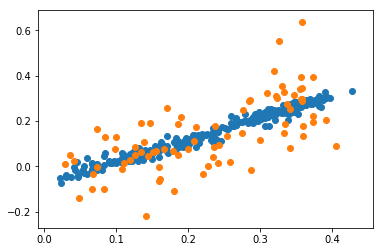

In [192]:
plt.scatter(y_train,model.predict(TS_train))
plt.scatter(y_test,model.predict(TS_test))

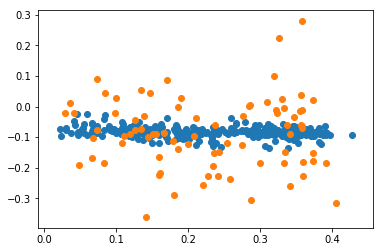

In [193]:
plt.scatter(y_train,np.ravel(model.predict(TS_train))-y_train)
plt.scatter(y_test,np.ravel(model.predict(TS_test))-y_test)

### Model taking entropy curves for 1D CNN + features in a dense network

In [167]:
nb_filter = 32
kernel_length = 3
window_size = np.shape(TS_input)[1]
nb_input_series = np.shape(TS_input)[2]
nb_outputs_1 = 64

input_1 = Input(shape=(window_size, nb_input_series), dtype='float32', name='input_1')
output_1 = Convolution1D(activation='relu', filters=nb_filter, kernel_size=kernel_length)(input_1)
output_1 = MaxPooling1D()(output_1)
output_1 = Flatten()(output_1)
output_1 = Dense(nb_outputs_1, activation='linear',name='output_1')(output_1)

input_2 = Input(shape=(np.shape(Feat)[1],),dtype='float32', name='input_2')
output_2 = keras.layers.normalization.BatchNormalization()(input_2)
#output_2 = Dense(256, activation='relu')(output_2)
output_2 = Dense(64, activation='relu', name='output_2')(output_2)

x = keras.layers.concatenate([output_1,output_2])
x = keras.layers.normalization.BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3, noise_shape=None, seed=None)(x)
x = Dense(64, activation='relu')(x)
#x = Dropout(0.3, noise_shape=None, seed=None)(x)
x = keras.layers.normalization.BatchNormalization()(x)

output = Dense(1, activation='linear')(x)

model = Model(inputs=[input_1, input_2], outputs=[output])
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy'])

In [168]:
model.fit([TS_train, Feat_train], [y_train], nb_epoch=1000, batch_size=320, validation_data=([TS_test,Feat_test], [y_test]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 320 samples, validate on 80 samples
Epoch 1/1000
320/320 [==============================] - 3s 8ms/step - loss: 4.6698 - acc: 0.0000e+00 - val_loss: 7.9920 - val_acc: 0.0000e+00
Epoch 2/1000
320/320 [==============================] - 0s 41us/step - loss: 4.8105 - acc: 0.0000e+00 - val_loss: 10.0975 - val_acc: 0.0000e+00
Epoch 3/1000
320/320 [==============================] - 0s 46us/step - loss: 4.1386 - acc: 0.0000e+00 - val_loss: 4.6342 - val_acc: 0.0000e+00
Epoch 4/1000
320/320 [==============================] - 0s 49us/step - loss: 4.4230 - acc: 0.0000e+00 - val_loss: 7.4572 - val_acc: 0.0000e+00
Epoch 5/1000
320/320 [==============================] - 0s 91us/step - loss: 4.5748 - acc: 0.0000e+00 - val_loss: 6.3119 - val_acc: 0.0000e+00
Epoch 6/1000
320/320 [==============================] - 0s 47us/step - loss: 4.5406 - acc: 0.0000e+00 - val_loss: 5.4599 - val_acc: 0.0000e+00
Epoch 7/1000
320/320 [==============================] - 0s 88us/step - loss: 4.5906 - acc: 0.0000

Epoch 58/1000
320/320 [==============================] - 0s 53us/step - loss: 3.4169 - acc: 0.0000e+00 - val_loss: 3.6599 - val_acc: 0.0000e+00
Epoch 59/1000
320/320 [==============================] - 0s 50us/step - loss: 3.3190 - acc: 0.0000e+00 - val_loss: 3.7323 - val_acc: 0.0000e+00
Epoch 60/1000
320/320 [==============================] - 0s 110us/step - loss: 3.7205 - acc: 0.0000e+00 - val_loss: 4.1491 - val_acc: 0.0000e+00
Epoch 61/1000
320/320 [==============================] - 0s 119us/step - loss: 3.6431 - acc: 0.0000e+00 - val_loss: 4.7988 - val_acc: 0.0000e+00
Epoch 62/1000
320/320 [==============================] - 0s 72us/step - loss: 3.3833 - acc: 0.0000e+00 - val_loss: 4.3041 - val_acc: 0.0000e+00
Epoch 63/1000
320/320 [==============================] - 0s 50us/step - loss: 3.3897 - acc: 0.0000e+00 - val_loss: 4.8187 - val_acc: 0.0000e+00
Epoch 64/1000
320/320 [==============================] - 0s 50us/step - loss: 3.3431 - acc: 0.0000e+00 - val_loss: 5.4378 - val_acc: 0

Epoch 115/1000
320/320 [==============================] - 0s 83us/step - loss: 3.3472 - acc: 0.0000e+00 - val_loss: 4.7470 - val_acc: 0.0000e+00
Epoch 116/1000
320/320 [==============================] - 0s 53us/step - loss: 3.3720 - acc: 0.0000e+00 - val_loss: 6.4975 - val_acc: 0.0000e+00
Epoch 117/1000
320/320 [==============================] - 0s 49us/step - loss: 3.3537 - acc: 0.0000e+00 - val_loss: 7.0458 - val_acc: 0.0000e+00
Epoch 118/1000
320/320 [==============================] - 0s 88us/step - loss: 3.5706 - acc: 0.0000e+00 - val_loss: 6.7334 - val_acc: 0.0000e+00
Epoch 119/1000
320/320 [==============================] - 0s 151us/step - loss: 3.5398 - acc: 0.0000e+00 - val_loss: 7.0316 - val_acc: 0.0000e+00
Epoch 120/1000
320/320 [==============================] - 0s 62us/step - loss: 3.2214 - acc: 0.0000e+00 - val_loss: 6.6655 - val_acc: 0.0000e+00
Epoch 121/1000
320/320 [==============================] - 0s 65us/step - loss: 3.3434 - acc: 0.0000e+00 - val_loss: 6.1903 - val_

Epoch 172/1000
320/320 [==============================] - 0s 50us/step - loss: 2.7578 - acc: 0.0000e+00 - val_loss: 3.1212 - val_acc: 0.0000e+00
Epoch 173/1000
320/320 [==============================] - 0s 193us/step - loss: 3.0463 - acc: 0.0000e+00 - val_loss: 3.1392 - val_acc: 0.0000e+00
Epoch 174/1000
320/320 [==============================] - 0s 48us/step - loss: 2.9917 - acc: 0.0000e+00 - val_loss: 3.0715 - val_acc: 0.0000e+00
Epoch 175/1000
320/320 [==============================] - 0s 44us/step - loss: 3.2122 - acc: 0.0000e+00 - val_loss: 3.0749 - val_acc: 0.0000e+00
Epoch 176/1000
320/320 [==============================] - 0s 46us/step - loss: 3.1508 - acc: 0.0000e+00 - val_loss: 3.1356 - val_acc: 0.0000e+00
Epoch 177/1000
320/320 [==============================] - 0s 41us/step - loss: 2.9760 - acc: 0.0000e+00 - val_loss: 3.0547 - val_acc: 0.0000e+00
Epoch 178/1000
320/320 [==============================] - 0s 79us/step - loss: 3.1432 - acc: 0.0000e+00 - val_loss: 2.9818 - val_

Epoch 229/1000
320/320 [==============================] - 0s 37us/step - loss: 2.8387 - acc: 0.0000e+00 - val_loss: 3.3468 - val_acc: 0.0000e+00
Epoch 230/1000
320/320 [==============================] - 0s 37us/step - loss: 2.8039 - acc: 0.0000e+00 - val_loss: 3.3401 - val_acc: 0.0000e+00
Epoch 231/1000
320/320 [==============================] - 0s 50us/step - loss: 2.7005 - acc: 0.0000e+00 - val_loss: 3.2921 - val_acc: 0.0000e+00
Epoch 232/1000
320/320 [==============================] - 0s 32us/step - loss: 2.8726 - acc: 0.0000e+00 - val_loss: 3.2881 - val_acc: 0.0000e+00
Epoch 233/1000
320/320 [==============================] - 0s 57us/step - loss: 2.4201 - acc: 0.0000e+00 - val_loss: 3.2884 - val_acc: 0.0000e+00
Epoch 234/1000
320/320 [==============================] - 0s 100us/step - loss: 2.6613 - acc: 0.0000e+00 - val_loss: 3.2833 - val_acc: 0.0000e+00
Epoch 235/1000
320/320 [==============================] - 0s 48us/step - loss: 2.5204 - acc: 0.0000e+00 - val_loss: 3.4067 - val_

Epoch 286/1000
320/320 [==============================] - 0s 50us/step - loss: 2.3138 - acc: 0.0000e+00 - val_loss: 3.2660 - val_acc: 0.0000e+00
Epoch 287/1000
320/320 [==============================] - 0s 50us/step - loss: 2.5009 - acc: 0.0000e+00 - val_loss: 3.2077 - val_acc: 0.0000e+00
Epoch 288/1000
320/320 [==============================] - 0s 88us/step - loss: 2.2702 - acc: 0.0000e+00 - val_loss: 3.0066 - val_acc: 0.0000e+00
Epoch 289/1000
320/320 [==============================] - 0s 50us/step - loss: 2.3737 - acc: 0.0000e+00 - val_loss: 2.9389 - val_acc: 0.0000e+00
Epoch 290/1000
320/320 [==============================] - 0s 109us/step - loss: 2.4092 - acc: 0.0000e+00 - val_loss: 3.0112 - val_acc: 0.0000e+00
Epoch 291/1000
320/320 [==============================] - 0s 45us/step - loss: 2.6172 - acc: 0.0000e+00 - val_loss: 3.3115 - val_acc: 0.0000e+00
Epoch 292/1000
320/320 [==============================] - 0s 162us/step - loss: 2.3031 - acc: 0.0000e+00 - val_loss: 2.3356 - val

Epoch 343/1000
320/320 [==============================] - 0s 41us/step - loss: 2.3467 - acc: 0.0000e+00 - val_loss: 3.0167 - val_acc: 0.0000e+00
Epoch 344/1000
320/320 [==============================] - 0s 63us/step - loss: 2.1466 - acc: 0.0000e+00 - val_loss: 2.9363 - val_acc: 0.0000e+00
Epoch 345/1000
320/320 [==============================] - 0s 38us/step - loss: 2.0229 - acc: 0.0000e+00 - val_loss: 3.0225 - val_acc: 0.0000e+00
Epoch 346/1000
320/320 [==============================] - 0s 42us/step - loss: 2.0581 - acc: 0.0000e+00 - val_loss: 3.0272 - val_acc: 0.0000e+00
Epoch 347/1000
320/320 [==============================] - 0s 50us/step - loss: 2.0960 - acc: 0.0000e+00 - val_loss: 3.0226 - val_acc: 0.0000e+00
Epoch 348/1000
320/320 [==============================] - 0s 83us/step - loss: 2.0862 - acc: 0.0000e+00 - val_loss: 3.6217 - val_acc: 0.0000e+00
Epoch 349/1000
320/320 [==============================] - 0s 66us/step - loss: 2.0641 - acc: 0.0000e+00 - val_loss: 3.5647 - val_a

Epoch 400/1000
320/320 [==============================] - 0s 37us/step - loss: 1.7493 - acc: 0.0000e+00 - val_loss: 1.8457 - val_acc: 0.0000e+00
Epoch 401/1000
320/320 [==============================] - 0s 62us/step - loss: 1.9090 - acc: 0.0000e+00 - val_loss: 1.8258 - val_acc: 0.0000e+00
Epoch 402/1000
320/320 [==============================] - 0s 38us/step - loss: 1.9876 - acc: 0.0000e+00 - val_loss: 1.8151 - val_acc: 0.0000e+00
Epoch 403/1000
320/320 [==============================] - 0s 44us/step - loss: 2.0613 - acc: 0.0000e+00 - val_loss: 1.8106 - val_acc: 0.0000e+00
Epoch 404/1000
320/320 [==============================] - 0s 44us/step - loss: 1.9297 - acc: 0.0000e+00 - val_loss: 1.8112 - val_acc: 0.0000e+00
Epoch 405/1000
320/320 [==============================] - 0s 122us/step - loss: 1.8892 - acc: 0.0000e+00 - val_loss: 1.7965 - val_acc: 0.0000e+00
Epoch 406/1000
320/320 [==============================] - 0s 44us/step - loss: 2.1136 - acc: 0.0000e+00 - val_loss: 1.7906 - val_

Epoch 457/1000
320/320 [==============================] - 0s 50us/step - loss: 1.7017 - acc: 0.0000e+00 - val_loss: 2.2286 - val_acc: 0.0000e+00
Epoch 458/1000
320/320 [==============================] - 0s 50us/step - loss: 1.7457 - acc: 0.0000e+00 - val_loss: 2.2223 - val_acc: 0.0000e+00
Epoch 459/1000
320/320 [==============================] - 0s 113us/step - loss: 1.6203 - acc: 0.0000e+00 - val_loss: 2.2017 - val_acc: 0.0000e+00
Epoch 460/1000
320/320 [==============================] - 0s 77us/step - loss: 1.6292 - acc: 0.0000e+00 - val_loss: 2.1547 - val_acc: 0.0000e+00
Epoch 461/1000
320/320 [==============================] - 0s 59us/step - loss: 1.6932 - acc: 0.0000e+00 - val_loss: 2.1191 - val_acc: 0.0000e+00
Epoch 462/1000
320/320 [==============================] - 0s 147us/step - loss: 1.6560 - acc: 0.0000e+00 - val_loss: 2.0555 - val_acc: 0.0000e+00
Epoch 463/1000
320/320 [==============================] - 0s 70us/step - loss: 1.7674 - acc: 0.0000e+00 - val_loss: 1.9928 - val

Epoch 514/1000
320/320 [==============================] - 0s 49us/step - loss: 1.5571 - acc: 0.0000e+00 - val_loss: 1.6963 - val_acc: 0.0000e+00
Epoch 515/1000
320/320 [==============================] - 0s 39us/step - loss: 1.5844 - acc: 0.0000e+00 - val_loss: 1.6865 - val_acc: 0.0000e+00
Epoch 516/1000
320/320 [==============================] - 0s 38us/step - loss: 1.6493 - acc: 0.0000e+00 - val_loss: 1.7813 - val_acc: 0.0000e+00
Epoch 517/1000
320/320 [==============================] - 0s 40us/step - loss: 1.5539 - acc: 0.0000e+00 - val_loss: 1.9580 - val_acc: 0.0000e+00
Epoch 518/1000
320/320 [==============================] - 0s 37us/step - loss: 1.4154 - acc: 0.0000e+00 - val_loss: 1.9072 - val_acc: 0.0000e+00
Epoch 519/1000
320/320 [==============================] - 0s 114us/step - loss: 1.4031 - acc: 0.0000e+00 - val_loss: 2.0432 - val_acc: 0.0000e+00
Epoch 520/1000
320/320 [==============================] - 0s 136us/step - loss: 1.4247 - acc: 0.0000e+00 - val_loss: 1.9852 - val

Epoch 571/1000
320/320 [==============================] - 0s 106us/step - loss: 1.4988 - acc: 0.0000e+00 - val_loss: 2.9375 - val_acc: 0.0000e+00
Epoch 572/1000
320/320 [==============================] - 0s 66us/step - loss: 1.4061 - acc: 0.0000e+00 - val_loss: 2.9280 - val_acc: 0.0000e+00
Epoch 573/1000
320/320 [==============================] - 0s 91us/step - loss: 1.5602 - acc: 0.0000e+00 - val_loss: 2.9220 - val_acc: 0.0000e+00
Epoch 574/1000
320/320 [==============================] - 0s 34us/step - loss: 1.2527 - acc: 0.0000e+00 - val_loss: 2.8099 - val_acc: 0.0000e+00
Epoch 575/1000
320/320 [==============================] - 0s 88us/step - loss: 1.3764 - acc: 0.0000e+00 - val_loss: 2.7426 - val_acc: 0.0000e+00
Epoch 576/1000
320/320 [==============================] - 0s 76us/step - loss: 1.3631 - acc: 0.0000e+00 - val_loss: 2.7017 - val_acc: 0.0000e+00
Epoch 577/1000
320/320 [==============================] - 0s 49us/step - loss: 1.3592 - acc: 0.0000e+00 - val_loss: 2.6087 - val_

Epoch 628/1000
320/320 [==============================] - 0s 45us/step - loss: 1.3292 - acc: 0.0000e+00 - val_loss: 2.3504 - val_acc: 0.0000e+00
Epoch 629/1000
320/320 [==============================] - 0s 37us/step - loss: 1.3001 - acc: 0.0000e+00 - val_loss: 2.3048 - val_acc: 0.0000e+00
Epoch 630/1000
320/320 [==============================] - 0s 112us/step - loss: 1.3139 - acc: 0.0000e+00 - val_loss: 3.1931 - val_acc: 0.0000e+00
Epoch 631/1000
320/320 [==============================] - 0s 44us/step - loss: 1.9518 - acc: 0.0000e+00 - val_loss: 3.0282 - val_acc: 0.0000e+00
Epoch 632/1000
320/320 [==============================] - 0s 90us/step - loss: 1.8449 - acc: 0.0000e+00 - val_loss: 2.9579 - val_acc: 0.0000e+00
Epoch 633/1000
320/320 [==============================] - 0s 62us/step - loss: 1.6417 - acc: 0.0000e+00 - val_loss: 2.8039 - val_acc: 0.0000e+00
Epoch 634/1000
320/320 [==============================] - 0s 35us/step - loss: 1.4402 - acc: 0.0000e+00 - val_loss: 2.7688 - val_

Epoch 685/1000
320/320 [==============================] - 0s 65us/step - loss: 1.0756 - acc: 0.0000e+00 - val_loss: 1.1828 - val_acc: 0.0000e+00
Epoch 686/1000
320/320 [==============================] - 0s 38us/step - loss: 1.4766 - acc: 0.0000e+00 - val_loss: 1.2457 - val_acc: 0.0000e+00
Epoch 687/1000
320/320 [==============================] - 0s 41us/step - loss: 1.2512 - acc: 0.0000e+00 - val_loss: 1.2797 - val_acc: 0.0000e+00
Epoch 688/1000
320/320 [==============================] - 0s 25us/step - loss: 1.1932 - acc: 0.0000e+00 - val_loss: 1.2816 - val_acc: 0.0000e+00
Epoch 689/1000
320/320 [==============================] - 0s 65us/step - loss: 1.2658 - acc: 0.0000e+00 - val_loss: 1.3171 - val_acc: 0.0000e+00
Epoch 690/1000
320/320 [==============================] - 0s 35us/step - loss: 1.2256 - acc: 0.0000e+00 - val_loss: 1.3372 - val_acc: 0.0000e+00
Epoch 691/1000
320/320 [==============================] - 0s 112us/step - loss: 1.1841 - acc: 0.0000e+00 - val_loss: 1.4567 - val_

Epoch 742/1000
320/320 [==============================] - 0s 50us/step - loss: 1.0039 - acc: 0.0000e+00 - val_loss: 1.0184 - val_acc: 0.0000e+00
Epoch 743/1000
320/320 [==============================] - 0s 50us/step - loss: 1.1838 - acc: 0.0000e+00 - val_loss: 1.7645 - val_acc: 0.0000e+00
Epoch 744/1000
320/320 [==============================] - 0s 245us/step - loss: 1.3441 - acc: 0.0000e+00 - val_loss: 1.1095 - val_acc: 0.0000e+00
Epoch 745/1000
320/320 [==============================] - 0s 34us/step - loss: 1.3535 - acc: 0.0000e+00 - val_loss: 1.2398 - val_acc: 0.0000e+00
Epoch 746/1000
320/320 [==============================] - 0s 54us/step - loss: 1.1515 - acc: 0.0000e+00 - val_loss: 1.1992 - val_acc: 0.0000e+00
Epoch 747/1000
320/320 [==============================] - 0s 44us/step - loss: 1.0490 - acc: 0.0000e+00 - val_loss: 1.1426 - val_acc: 0.0000e+00
Epoch 748/1000
320/320 [==============================] - 0s 40us/step - loss: 1.1941 - acc: 0.0000e+00 - val_loss: 1.3604 - val_

Epoch 799/1000
320/320 [==============================] - 0s 51us/step - loss: 0.9226 - acc: 0.0000e+00 - val_loss: 1.1881 - val_acc: 0.0000e+00
Epoch 800/1000
320/320 [==============================] - 0s 100us/step - loss: 0.9353 - acc: 0.0000e+00 - val_loss: 1.1048 - val_acc: 0.0000e+00
Epoch 801/1000
320/320 [==============================] - 0s 51us/step - loss: 0.8931 - acc: 0.0000e+00 - val_loss: 1.1249 - val_acc: 0.0000e+00
Epoch 802/1000
320/320 [==============================] - 0s 50us/step - loss: 0.9600 - acc: 0.0000e+00 - val_loss: 1.1239 - val_acc: 0.0000e+00
Epoch 803/1000
320/320 [==============================] - 0s 98us/step - loss: 0.9944 - acc: 0.0000e+00 - val_loss: 1.1720 - val_acc: 0.0000e+00
Epoch 804/1000
320/320 [==============================] - 0s 33us/step - loss: 0.9663 - acc: 0.0000e+00 - val_loss: 1.2067 - val_acc: 0.0000e+00
Epoch 805/1000
320/320 [==============================] - 0s 154us/step - loss: 0.9519 - acc: 0.0000e+00 - val_loss: 1.1981 - val

Epoch 856/1000
320/320 [==============================] - 0s 38us/step - loss: 0.8970 - acc: 0.0000e+00 - val_loss: 1.0812 - val_acc: 0.0000e+00
Epoch 857/1000
320/320 [==============================] - 0s 43us/step - loss: 0.8986 - acc: 0.0000e+00 - val_loss: 1.0224 - val_acc: 0.0000e+00
Epoch 858/1000
320/320 [==============================] - 0s 46us/step - loss: 1.0094 - acc: 0.0000e+00 - val_loss: 1.0546 - val_acc: 0.0000e+00
Epoch 859/1000
320/320 [==============================] - 0s 43us/step - loss: 0.9131 - acc: 0.0000e+00 - val_loss: 1.0119 - val_acc: 0.0000e+00
Epoch 860/1000
320/320 [==============================] - 0s 95us/step - loss: 0.8496 - acc: 0.0000e+00 - val_loss: 1.0105 - val_acc: 0.0000e+00
Epoch 861/1000
320/320 [==============================] - 0s 48us/step - loss: 0.9316 - acc: 0.0000e+00 - val_loss: 1.0096 - val_acc: 0.0000e+00
Epoch 862/1000
320/320 [==============================] - 0s 88us/step - loss: 1.0805 - acc: 0.0000e+00 - val_loss: 0.9906 - val_a

Epoch 913/1000
320/320 [==============================] - 0s 38us/step - loss: 0.8098 - acc: 0.0000e+00 - val_loss: 1.3602 - val_acc: 0.0000e+00
Epoch 914/1000
320/320 [==============================] - 0s 50us/step - loss: 0.7950 - acc: 0.0000e+00 - val_loss: 1.2929 - val_acc: 0.0000e+00
Epoch 915/1000
320/320 [==============================] - 0s 37us/step - loss: 0.8396 - acc: 0.0000e+00 - val_loss: 1.2737 - val_acc: 0.0000e+00
Epoch 916/1000
320/320 [==============================] - 0s 125us/step - loss: 0.8130 - acc: 0.0000e+00 - val_loss: 1.2692 - val_acc: 0.0000e+00
Epoch 917/1000
320/320 [==============================] - 0s 50us/step - loss: 0.9046 - acc: 0.0000e+00 - val_loss: 1.1635 - val_acc: 0.0000e+00
Epoch 918/1000
320/320 [==============================] - 0s 75us/step - loss: 0.7471 - acc: 0.0000e+00 - val_loss: 1.2135 - val_acc: 0.0000e+00
Epoch 919/1000
320/320 [==============================] - 0s 50us/step - loss: 0.8067 - acc: 0.0000e+00 - val_loss: 1.2048 - val_

Epoch 970/1000
320/320 [==============================] - 0s 50us/step - loss: 0.7152 - acc: 0.0000e+00 - val_loss: 0.8739 - val_acc: 0.0000e+00
Epoch 971/1000
320/320 [==============================] - 0s 37us/step - loss: 0.7657 - acc: 0.0000e+00 - val_loss: 0.8121 - val_acc: 0.0000e+00
Epoch 972/1000
320/320 [==============================] - 0s 75us/step - loss: 0.6808 - acc: 0.0000e+00 - val_loss: 0.8214 - val_acc: 0.0000e+00
Epoch 973/1000
320/320 [==============================] - 0s 50us/step - loss: 0.7055 - acc: 0.0000e+00 - val_loss: 0.7655 - val_acc: 0.0000e+00
Epoch 974/1000
320/320 [==============================] - 0s 50us/step - loss: 0.8216 - acc: 0.0000e+00 - val_loss: 0.8910 - val_acc: 0.0000e+00
Epoch 975/1000
320/320 [==============================] - 0s 43us/step - loss: 0.7521 - acc: 0.0000e+00 - val_loss: 0.8191 - val_acc: 0.0000e+00
Epoch 976/1000
320/320 [==============================] - 0s 32us/step - loss: 0.6944 - acc: 0.0000e+00 - val_loss: 0.7959 - val_a

1.0


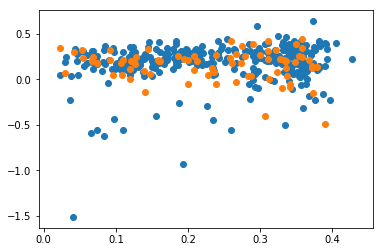

In [169]:
y_pred = model.predict([TS_test,Feat_test])

#plt.scatter(y_train,model.predict(TS_train))
#plt.scatter(y_test,model.predict(TS_test))

#plt.scatter(y_train,model.predict([TS_train,Feat_train]))
#plt.scatter(y_test,model.predict([TS_test,Feat_test]))

y_pred = model.predict([TS_test,Feat_test])
y_pred2 = y_pred
it = 0.0
for i in range(len(y_pred)):
    if np.abs(y_pred[i]) >= 1.0:
        y_pred2[i] = 0.0
        it +=1

plt.scatter(y_train,model.predict([TS_train,Feat_train]))
plt.scatter(y_test, y_pred2)
print(it)

1.0


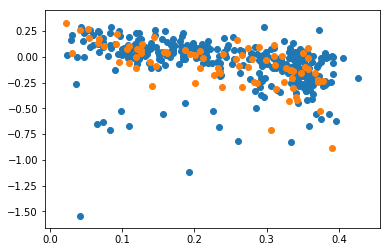

In [170]:
#plt.scatter(y_train,np.ravel(model.predict(TS_train))-y_train)
#plt.scatter(y_test,np.ravel(model.predict(TS_test))-y_test)

#plt.scatter(y_train,np.ravel(model.predict([TS_train,Feat_train]))-y_train)
#plt.scatter(y_test,np.ravel(model.predict([TS_test,Feat_test]))-y_test)

y_pred = model.predict([TS_test,Feat_test])
y_pred2 = y_pred
it = 0.0
for i in range(len(y_pred)):
    if np.abs(y_pred[i]) >= 1.0:
        y_pred2[i] = 0.0
        it +=1

plt.scatter(y_train,np.ravel(model.predict([TS_train,Feat_train]))-y_train)
plt.scatter(y_test,np.ravel(y_pred2)-y_test)
print(it)